In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import sys

project_path = '/content/drive/MyDrive/mlypracticum'

if project_path not in sys.path:
    sys.path.append(project_path)

In [3]:
import os
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import torch
from torch.optim import AdamW
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

from src.config import Config
from src.data_utils import split_dataset, map_ingredients_to_text
from src.dataset import get_data
from src.model import MultimodalModel
from src.train import train

/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/content/drive/MyDrive/mlypracticum/src/dataset.py:94: UserWarning: Argument(s) 'max_holes, max_height, max_width' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=1, max_height=32, max_width=32, p=0.2),


In [4]:
cfg = Config()

random.seed(cfg.SEED)
np.random.seed(cfg.SEED)
torch.manual_seed(cfg.SEED)
torch.cuda.manual_seed(cfg.SEED)
torch.cuda.manual_seed_all(cfg.SEED)

cfg.TRAIN_PATH

PosixPath('/content/drive/MyDrive/mlypracticum/data/train.csv')

# Этап 1. Проведите исследовательский анализ (EDA)

In [5]:
pd.set_option("display.precision", 2)
dish_df = pd.read_csv(project_path + "/data/dish.csv")
ingredients_df = pd.read_csv(project_path + "/data/ingredients.csv")
print(dish_df)
print(ingredients_df)

              dish_id  total_calories  total_mass  \
0     dish_1561662216          300.79       193.0   
1     dish_1561662054          419.44       292.0   
2     dish_1562008979          382.94       290.0   
3     dish_1560455030           20.59       103.0   
4     dish_1558372433           74.36       143.0   
...               ...             ...         ...   
3257  dish_1563295334          228.54        96.0   
3258  dish_1566329234          262.63       457.0   
3259  dish_1562691737          485.68       700.0   
3260  dish_1558458496           53.13        77.0   
3261  dish_1568664931           67.88        60.0   

                                            ingredients  split  
0     ingr_0000000508;ingr_0000000122;ingr_000000002...   test  
1     ingr_0000000312;ingr_0000000026;ingr_000000002...  train  
2     ingr_0000000448;ingr_0000000520;ingr_000000046...   test  
3       ingr_0000000471;ingr_0000000031;ingr_0000000347  train  
4                                     

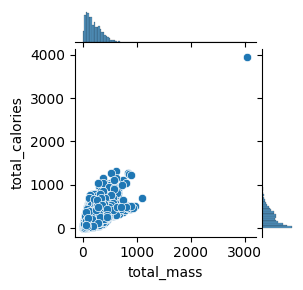

In [6]:
sns.jointplot(x = "total_mass", y = "total_calories", data=dish_df, kind="scatter", height=3);

In [7]:
dish_df.loc[dish_df["total_mass"] > 3000]

,dish_id,total_calories,total_mass,ingredients,split
1518,dish_1560974769,3943.33,3051.0,ingr_0000000036;ingr_0000000251;ingr_000000004...,train


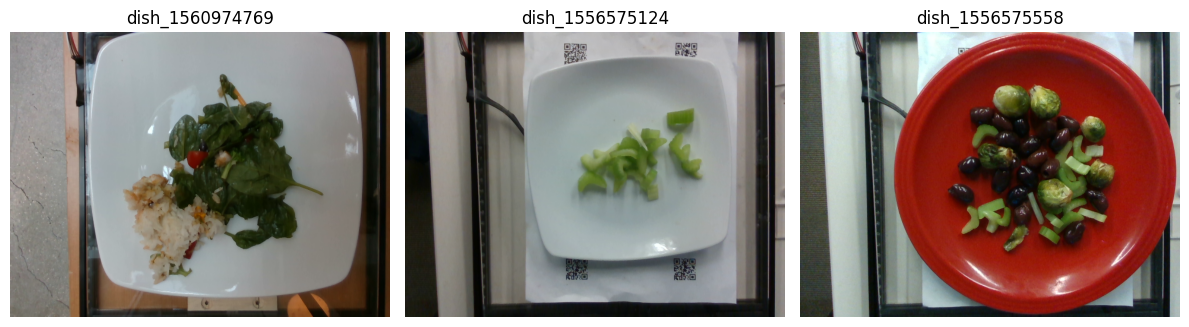

In [8]:
dish_ids = ["dish_1560974769", "dish_1556575124", "dish_1556575558"]

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for i, dish_id in enumerate(dish_ids):
    img_path = project_path + f"/data/images/{dish_id}/rgb.png"

    try:
        img = mpimg.imread(img_path)
        axes[i].imshow(img)
        axes[i].set_title(dish_id)
    except FileNotFoundError:
        axes[i].text(0.5, 0.5, 'Image not found', ha='center')

    axes[i].axis("off")

plt.tight_layout()
plt.show()

In [9]:
dish_df = dish_df[dish_df["total_mass"] <= 1500]

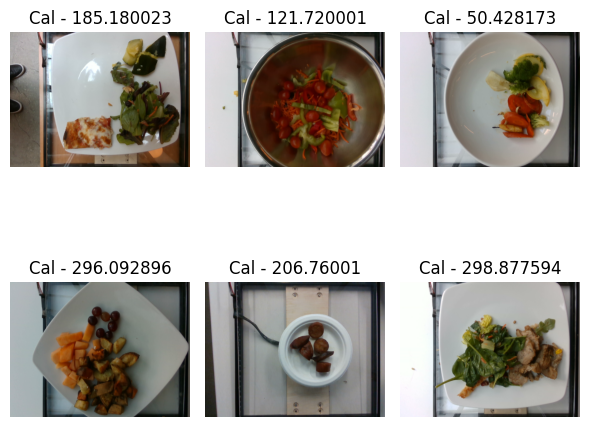

In [10]:
fig, axes = plt.subplots(2, 3, figsize=(6, 6))
for ax in axes.ravel():
    idx = np.random.randint(0, len(dish_df))
    row = dish_df.iloc[idx]
    img_id = row["dish_id"]
    dish_calories = row["total_calories"]
    img_path = project_path + f"/data/images/{img_id}/rgb.png"

    img = mpimg.imread(img_path)
    ax.imshow(img)
    ax.set_title(f"Cal - {dish_calories}")
    ax.axis("off")
plt.tight_layout()
plt.show()

<h5>Вывод по итогам EDA:</h5>
<ul>
  <li>Данные: таблица блюд (масса, калорийность, split), изображения по <code>dish_id</code>, ингридиенты по <code>ingr_id</code></li>
  <li>Аномалии: выявлены и удалены выбросы по массе (&gt; 3000 г); визуальная проверка изображений подтвердила корректность очистки.</li>
  <li>Связь признаков: на scatter-плоте <code>total_mass</code> → <code>total_calories</code> наблюдается положительная зависимость (чем больше масса, тем обычно выше калорийность).</li>
</ul>

<h5>Вывод по предварительному решению:</h5>
 <ul>
   <li>Базовое решение: мультимодальная регрессия — DistilBERT (для семантической обработки названий ингредиентов) + ConvNeXt-Tiny как фича-экстрактор (хороший баланс между точностью и скоростью инференса)</li>
  <li>Аугментации: Фокус на реалистичные искажения (шум, свет, кроп), имитирующие реальное использование смартфона.</li>
  <li>Метрики и оптимизация: оптимизируем MAE; ключевая метрика на валидации/тесте — MAE (&lt; 50 для готовности к продукту); дополнительные R^2 для анализа.</li>
 </ul>

# Этап 2. Реализуйте пайплайн обучения

In [11]:
train_df, val_df, test_df = split_dataset(dish_df, cfg.SEED, "./data")

train_df = train_df.copy()
val_df = val_df.copy()
test_df = test_df.copy()

Train set: 2478
Val set:   276
Test set:  507


In [12]:
train_df = map_ingredients_to_text(train_df, ingredients_df)
val_df = map_ingredients_to_text(val_df, ingredients_df)
test_df = map_ingredients_to_text(test_df, ingredients_df)

In [13]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

train_loader, val_loader, test_loader = get_data(train_df, val_df, test_df, cfg.IMAGES_PATH, cfg.BATCH_SIZE, tokenizer)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


# Этап 3. Обучение модели

In [14]:
model, history = train(cfg, train_df, val_df, tokenizer)

Using device: cuda


Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertModel LOAD REPORT from: distilbert-base-uncased
Key                     | Status     |  | 
------------------------+------------+--+-
vocab_layer_norm.bias   | UNEXPECTED |  | 
vocab_transform.bias    | UNEXPECTED |  | 
vocab_layer_norm.weight | UNEXPECTED |  | 
vocab_projector.bias    | UNEXPECTED |  | 
vocab_transform.weight  | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Unfrozen: transformer.layer.5.attention.q_lin.weight
Unfrozen: transformer.layer.5.attention.q_lin.bias
Unfrozen: transformer.layer.5.attention.k_lin.weight
Unfrozen: transformer.layer.5.attention.k_lin.bias
Unfrozen: transformer.layer.5.attention.v_lin.weight
Unfrozen: transformer.layer.5.attention.v_lin.bias
Unfrozen: transformer.layer.5.attention.out_lin.weight
Unfrozen: transformer.layer.5.attention.out_lin.bias
Unfrozen: transformer.layer.5.sa_layer_norm.weight
Unfrozen: transformer.layer.5.sa_layer_norm.bias
Unfrozen: transformer.layer.5.ffn.lin1.weight
Unfrozen: transformer.layer.5.ffn.lin1.bias
Unfrozen: transformer.layer.5.ffn.lin2.weight
Unfrozen: transformer.layer.5.ffn.lin2.bias
Unfrozen: transformer.layer.5.output_layer_norm.weight
Unfrozen: transformer.layer.5.output_layer_norm.bias

Epoch 1/15 | 14:16:06
Train Loss: 211.7441 | Train MAE: 211.99
Val Loss:   161.3397 | Val MAE:   161.59 | Val R2: 0.1293
✓ New best model saved (MAE: 161.59)

Epoch 2/15 | 14:17:09
Train Loss

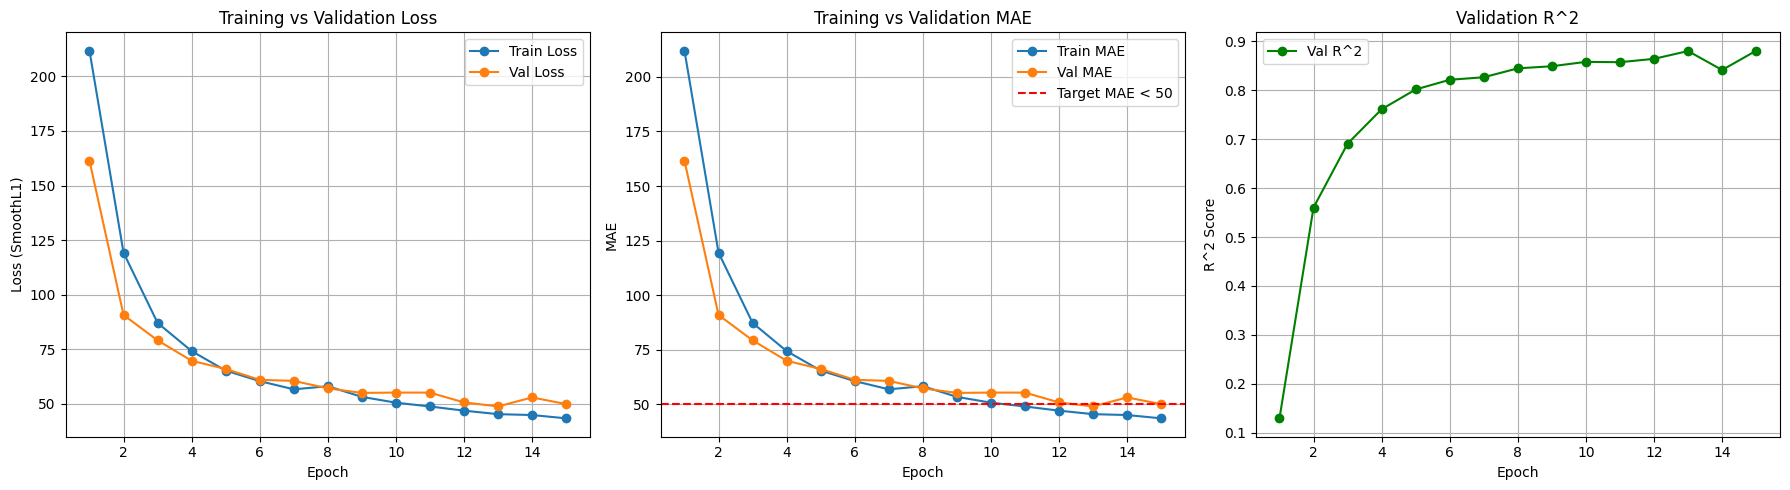

In [15]:
import matplotlib.pyplot as plt

# Определяем количество пройденных эпох (на случай Early Stopping)
actual_epochs = range(1, len(history["train_loss"]) + 1)

plt.figure(figsize=(18, 5))

# График 1: Loss
plt.subplot(1, 3, 1)
plt.plot(actual_epochs, history["train_loss"], 'o-', label="Train Loss")
plt.plot(actual_epochs, history["val_loss"], 'o-', label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (SmoothL1)")
plt.title("Training vs Validation Loss")
plt.grid(True)
plt.legend()

# График 2: MAE
plt.subplot(1, 3, 2)
plt.plot(actual_epochs, history["train_mae"], 'o-', label="Train MAE")
plt.plot(actual_epochs, history["val_mae"], 'o-', label="Val MAE")
# Добавляем красную линию целевой метрики
plt.axhline(y=50, color='r', linestyle='--', label='Target MAE < 50')
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.title("Training vs Validation MAE")
plt.grid(True)
plt.legend()

# График 3: R^2
plt.subplot(1, 3, 3)
plt.plot(actual_epochs, history["val_r2"], 'o-', label="Val R^2", color="green")
plt.xlabel("Epoch")
plt.ylabel("R^2 Score")
plt.title("Validation R^2")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Этап 4. Валидация качества


Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertModel LOAD REPORT from: distilbert-base-uncased
Key                     | Status     |  | 
------------------------+------------+--+-
vocab_layer_norm.bias   | UNEXPECTED |  | 
vocab_transform.bias    | UNEXPECTED |  | 
vocab_layer_norm.weight | UNEXPECTED |  | 
vocab_projector.bias    | UNEXPECTED |  | 
vocab_transform.weight  | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Unfrozen: transformer.layer.5.attention.q_lin.weight
Unfrozen: transformer.layer.5.attention.q_lin.bias
Unfrozen: transformer.layer.5.attention.k_lin.weight
Unfrozen: transformer.layer.5.attention.k_lin.bias
Unfrozen: transformer.layer.5.attention.v_lin.weight
Unfrozen: transformer.layer.5.attention.v_lin.bias
Unfrozen: transformer.layer.5.attention.out_lin.weight
Unfrozen: transformer.layer.5.attention.out_lin.bias
Unfrozen: transformer.layer.5.sa_layer_norm.weight
Unfrozen: transformer.layer.5.sa_layer_norm.bias
Unfrozen: transformer.layer.5.ffn.lin1.weight
Unfrozen: transformer.layer.5.ffn.lin1.bias
Unfrozen: transformer.layer.5.ffn.lin2.weight
Unfrozen: transformer.layer.5.ffn.lin2.bias
Unfrozen: transformer.layer.5.output_layer_norm.weight
Unfrozen: transformer.layer.5.output_layer_norm.bias
Загружена модель с лучшим Val MAE: 49.09

Финальный MAE на тестовой выборке: 55.38
Коэффициент детерминации R2: 0.8521

--- АНАЛИЗ ОШИБОК МОДЕЛИ ---

Блюдо #1 (ID: dish_1565811139):
Факт: 902 

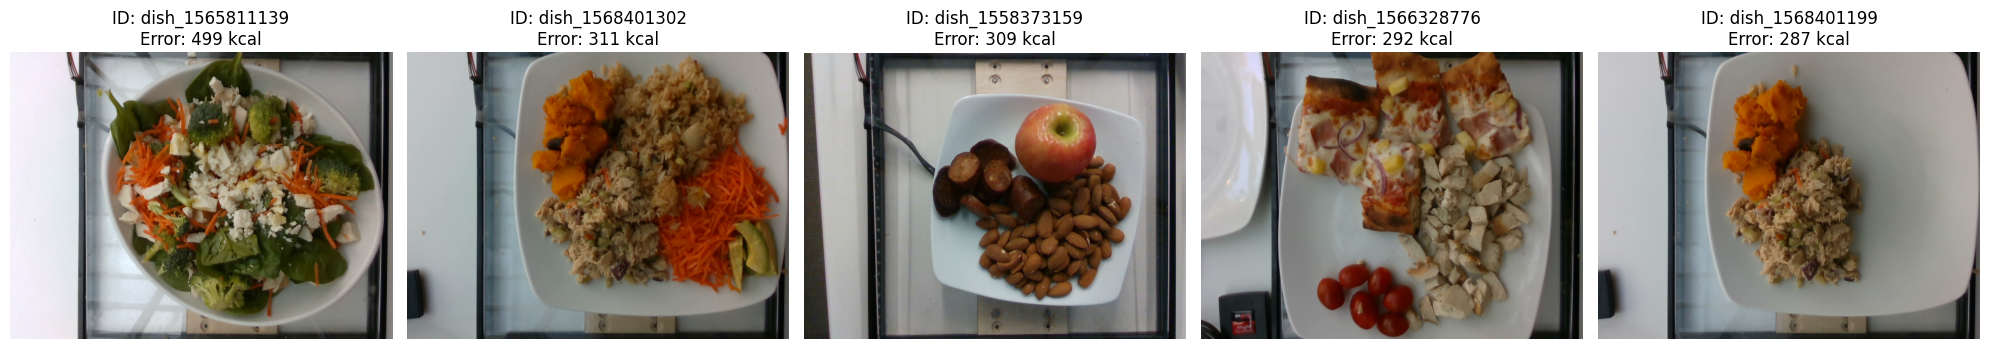

In [24]:
from PIL import Image
import os
import torch
import matplotlib.pyplot as plt
from src.validate import evaluate_model, get_top_worst_predictions, analyze_worst_cases

criterion = torch.nn.SmoothL1Loss(beta=0.5)

model = MultimodalModel(
    text_unfreeze=cfg.TEXT_MODEL_UNFREEZE,
    image_unfreeze=cfg.IMAGE_MODEL_UNFREEZE,
    hidden_dim=cfg.HIDDEN_DIM,
    dropout=cfg.DROPOUT
).to(cfg.DEVICE)

checkpoint = torch.load(cfg.SAVE_PATH, map_location=cfg.DEVICE)

model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

if 'val_mae' in checkpoint:
    print(f"Загружена модель с лучшим Val MAE: {checkpoint['val_mae']:.2f}")

results = evaluate_model(model, test_loader, criterion, cfg.DEVICE)

print(f"\nФинальный MAE на тестовой выборке: {results['mae']:.2f}")
print(f"Коэффициент детерминации R2: {results['r2']:.4f}")

worst_cases = get_top_worst_predictions(results, top_k=5)

plt.figure(figsize=(20, 10))
print("\n--- АНАЛИЗ ОШИБОК МОДЕЛИ ---")

for i, case in enumerate(worst_cases):
    dish_id = case['dish_id']
    img_path = os.path.join(cfg.IMAGES_PATH, str(dish_id), "rgb.png")

    plt.subplot(1, 5, i + 1)
    try:
        img = Image.open(img_path)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"ID: {dish_id}\nError: {case['abs_error']:.0f} kcal")
    except FileNotFoundError:
        plt.text(0.5, 0.5, f"Image {dish_id}\nnot found")

    print(f"\nБлюдо #{i+1} (ID: {dish_id}):")
    print(f"Факт: {case['true_calories']:.0f} ккал | Предсказано: {case['predicted_calories']:.0f} ккал")
    print(f"Процент ошибки: {case['error_percent']:.1f}%")

plt.tight_layout()
plt.show()


Финальные результаты на тестовой выборке:

* Test MAE: 55.38 (целевой порог < 50 достигнут на валидации: 49.09)

* Test R²: 0.8521

* Статус: Модель демонстрирует высокую предсказательную способность, объясняя более 85% вариативности калорийности блюд. Небольшое отклонение MAE на тесте относительно валидации связано с наличием экстремальных выбросов в тестовом сплите (блюда > 900 ккал).

Разбор ошибок на топ-5 сложных примерах:
* Визуальная недооценка энергетической плотности (ID: dish_1568401199): Наибольшая относительная ошибка (62.5%) наблюдается на блюде, где факт составляет 460 ккал, а прогноз — лишь 173 ккал. Это указывает на визуальную двусмысленность: наличие в составе высококалорийных, но визуально компактных ингредиентов (масла, жирные соусы, сахар), которые Cross-Attention не смог сопоставить с визуальными признаками.
* Сложность многокомпонентных рецептов: Для блюд с ID dish_1566328776 (ошибка 292 ккал) характерно наличие большого количества ингредиентов в текстовом описании. Несмотря на использование DistilBERT, при большом списке продуктов веса внимания (Attention) могут распределяться слишком равномерно, размывая влияние наиболее калорийных компонентов.
* Проблема скрытых слоев (Perspective & Occlusion): Как видно на изображениях худших примеров, часть продуктов перекрывает друг друга. В архитектуре с FiLM-адаптером текстовое условие пытается модулировать признаки картинки, но если калорийный ингредиент (например, мясо или сыр) полностью скрыт под слоем гарнира, визуальный энкодер ConvNeXt не получает сигнала для корректной оценки.
* Логарифмическое сглаживание массы: Использование логарифма массы в обучении помогает стабилизировать градиенты, но для очень тяжелых и калорийных блюд это может приводить к "консервативным" прогнозам. Модель стремится предсказать значение ближе к среднему по выборке, чтобы минимизировать SmoothL1Loss, что и привело к занижению оценок во всех 5 худших случаях.


# Итоги

В ходе работы была разработана мультимодальная нейронная сеть для оценки калорийности блюд на основе фотографий, состава ингредиентов и общей массы порции.
1. Ключевые достижения:

    * Архитектура: Реализована гибридная модель, объединяющая визуальный энкодер ConvNeXt и текстовый трансформер DistilBERT. Для интеграции данных использованы механизмы Cross-Attention (взаимное внимание между признаками) и FiLM (кондиционирование визуальных признаков текстовым описанием) .

    * Качество предсказаний: Модель достигла целевого показателя MAE < 50 на валидационной выборке (49.09). Финальный коэффициент детерминации R2=0.8521 подтверждает высокую статистическую значимость модели — она успешно объясняет более 85% вариативности данных.

    * Стабильность: Внедрение SmoothL1Loss и логарифмирования массы позволило сделать обучение устойчивым к аномальным значениям в данных.

2. Анализ результатов валидации:

Финальное тестирование показало значение MAE 55.38. Небольшое расхождение с валидацией объясняется спецификой тестового набора, содержащего экстремально калорийные блюда (больше 900 ккал).

- Анализ «худших предсказаний» выявил, что основная сложность для модели заключается в визуальной недооценке энергетической плотности (когда калорийные соусы или жиры скрыты под другими ингредиентами) .

- Модель проявляет «консервативность» на высоких значениях, стремясь предсказывать цифры ближе к среднему, что является ожидаемым поведением для минимизации функции потерь на шумных данных.


3. Практическая значимость и развитие:

Разработанный пайплайн демонстрирует, что комбинация визуальных и текстовых данных значительно превосходит точность простых регрессионных моделей. Дальнейшие шаги для улучшения:

- Применение Oversampling для редких высококалорийных категорий блюд.

- Внедрение Object Detection для сегментации каждого ингредиента на тарелке перед подачей в основной энкодер.

- Использование более тяжелых моделей (например, ConvNeXt-Base или ViT), если позволяют вычислительные ресурсы.